## LAB 4

### 1. 의사 결정 나무

### 데이터 설명

- 설명변수 (25개) 
    - ID, AGE, INCOME, SEX, MARRIED (1: 결혼, 0: 미혼)
    - FICO (신용점수), OWNHOME (자가 주택 소유 여부, 1: 소유), LOC (거주지, A-H)
    - BUY6, 12, 18 (최근 6, 12, 18개월 간의 구입 횟수),VALUE24 (지난 24개월 간의 구입 총액),ORGSRC (고객 분류), DISCBUY (할인 고객 여부, 1: 할인 고객), RETURN24 (지난 24개월 간 상품 반품 여부), COA6 (6개월 간의 주소변경 여부, 1: 주소변경)
- 반응변수: RESPOND (DM에 대한 반응 여부)

In [125]:
import numpy as np
import pandas as pd

buytest = pd.read_csv('buytest.txt', sep = ' ')
buytest.index = buytest.iloc[:,0]
buytest = buytest.iloc[:,1:]

buytest = buytest.dropna(axis = 0)

buytest = buytest.iloc[:,:-8]
buytest.head()

buytest = pd.get_dummies(buytest, drop_first = True)

print(buytest.shape)

#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

import statsmodels.api as sm
train, test = train_test_split(buytest, test_size = 0.3, random_state = 320)
X_train, y_train = train.drop('RESPOND', axis = 1), train.RESPOND
X_test, y_test = test.drop('RESPOND', axis = 1), test.RESPOND



(9221, 28)


- DecisionTreeClassifier(criterion, splitter, max_depth, max_features, min_samples_leaf=5, min_samples_split=2, ...)

In [126]:
from sklearn import tree
from sklearn.metrics import confusion_matrix

d_tree = tree.DecisionTreeClassifier(criterion = 'gini', )
d_tree.fit(X_train, y_train)
print('Accuracy for selected model : %.4f' %np.mean(d_tree.predict(X_test) == y_test) )
confusion_matrix(y_test,d_tree.predict(X_test))

Accuracy for selected model : 0.8580


array([[2345,  221],
       [ 172,   29]])

In [127]:
d_tree_maxdepth = tree.DecisionTreeClassifier(max_depth = 3)
d_tree_maxdepth.fit(X_train, y_train)
print('Accuracy for selected model : %.4f' %np.mean(d_tree_maxdepth.predict(X_test) == y_test) )
confusion_matrix(y_test,d_tree_maxdepth.predict(X_test))

Accuracy for selected model : 0.9270


array([[2564,    2],
       [ 200,    1]])

In [128]:
pred = d_tree_maxdepth.predict_proba(X_test)[:,1]
ind_prob = np.logical_and((pred != 0 ), (pred != 1))
print(np.sum(np.logical_and((pred != 0 ), (pred != 1))))
print(pred[ind_prob])

2767
[ 0.10574949  0.05713679  0.05713679 ...,  0.10574949  0.08474576
  0.13733906]


### 2. 부스팅

### 자료 설명
- 한 유니버셜뱅크의 고객에 대한 인구통계자료, 금융자료
- 14개의 변수와 5,000개의 관측값으로 구성 - 분석에는 ZIP Code와 ID를 제외한 12개의 변수를 사용
- 변수 설명
    - Age : 나이
    - Experience : 근속 년수
    - Income : 연소득 ($\$$1,000)
    - Family : 가족 구성원 수
    - CCAvg : 월별 신용카드 평균 사용액
    - Education : 교육수준(고졸 = 1, 대졸 = 2, 대졸 이상 = 3)
    - Mortgage : 주택 담보 대출액($\$$1,000)
    - Personal Loan : 개인 대출 가능 여부(yes = 1, no = 0)
    - Securities Account : 증권 계좌 개설 여부(yes = 1, no = 0)
    - CD Account : CD 계좌 개설 여부(yes = 1, no = 0)
    - Online : 온라인 뱅킹 개설 여부(yes = 1, no = 0)
    - CreditCard : 신용 카드 발급 여부(yes = 1, no = 0)
    

### 분석 목적 : 고객의 개인 대출 가능 여부 확률 $P(\text{Personal Loan} = 1 | data)$을 추정

In [129]:
unibank = pd.read_csv('UniversalBank.csv', delimiter = ',')
unibank = unibank.drop('ID',axis=1).drop('ZIP Code', axis = 1)
print(unibank.shape)
unibank.head()

(5000, 12)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


### 자료 전처리 1: 결측치 수 확인

#### 결측치가 없는 것을 확인할 수 있다.

In [130]:
unibank.isnull().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

### 자료 전처리 2: 범주형 변수 가변수화(Education)

- Education 변수의 경우, 고졸과 대졸간의 차이가 대졸과 대졸 이상 학력간의 차이와 동일하다고 말할 수 없다.
- 따라서 이는 숫자형 변수가 아닌 범주형 변수로 간주해야 한다.
- 분석을 위해 가변수를 생성하자.

In [131]:
edu = np.array(['Undergrad', 'Graduate', 'Advanced'])
unibank.Education = edu[np.array(unibank.Education-1)]
unibank = pd.get_dummies(unibank, drop_first = True)
unibank.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Education_Graduate,Education_Undergrad
0,25,1,49,4,1.6,0,0,1,0,0,0,0.0,1.0
1,45,19,34,3,1.5,0,0,1,0,0,0,0.0,1.0
2,39,15,11,1,1.0,0,0,0,0,0,0,0.0,1.0
3,35,9,100,1,2.7,0,0,0,0,0,0,1.0,0.0
4,35,8,45,4,1.0,0,0,0,0,0,1,1.0,0.0


### 자료 전처리 3: 학습자료 / 시험자료 분리

In [159]:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
train, test = train_test_split(unibank, test_size = 0.3, random_state = 1)
train1, val = train_test_split(train, test_size = 0.3, random_state = 1)

X_train, y_train = train.drop("Personal Loan", axis = 1), train['Personal Loan']
X_test, y_test = test.drop("Personal Loan", axis = 1), test['Personal Loan']
X_train1, y_train1 = train1.drop("Personal Loan", axis = 1), train1['Personal Loan']
X_val, y_val = val.drop("Personal Loan", axis = 1), val['Personal Loan']

### 배깅 (Bagging)

In [160]:
import sklearn.ensemble as ensemble

acc = []
for i in range(10):
    Bagging = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=2), n_estimators = i+1, random_state=42)
    Bagging.fit(X_train1, y_train1)
    acc.append(np.mean(Bagging.predict(X_train1) == y_train1))
    

In [161]:
acc

[0.96448979591836737,
 0.9681632653061224,
 0.9681632653061224,
 0.95959183673469384,
 0.9620408163265306,
 0.9620408163265306,
 0.9620408163265306,
 0.96244897959183673,
 0.95510204081632655,
 0.96244897959183673]

In [162]:
Bagging = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=3), n_estimators = 300, random_state=42)
Bagging.fit(X_train1, y_train1)
np.mean(Bagging.predict(X_train1) == y_train1)

0.983265306122449

In [163]:
np.mean(Bagging.predict(X_test) == y_test)

0.97399999999999998

### 랜덤포레스트 (RandomForest)


In [165]:
RandomForest = ensemble.RandomForestClassifier(max_depth=3, n_estimators =300, random_state = 42)
RandomForest.fit(X_train1, y_train1)
np.mean(RandomForest.predict(X_test) == y_test)

0.93400000000000005

### 부스팅 (Boosting)

- sklearn.ensemble의 GradientBoostingClassifier 클래스 사용
- 옵션
    - loss - 'deviance' : 로짓 부스팅, 'exponential' : Adaboost
    - learning_rate : 축소 계수. 추정한 의사결정나무를 어느정도 반영할지를 결정하는 값이다.
    - n_estimator : 모형을 구성하는 의사 결정 나무의 개수
    - max_depth : 각 의사 결정 나무의 깊이. default = 3. max_depth = 1인 모형을 사용하면 뛰어난 설명력을 갖는 모형을 만들 수 있다.

In [166]:
Boosting = ensemble.GradientBoostingClassifier(loss = 'deviance', learning_rate = 0.1, n_estimators = 100, max_depth = 1, random_state = 0)
Boosting.fit(X_train1, y_train1)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

#### 학습오차, 시험오차 확인

In [167]:
print('Gradient boosting model')
acc = np.mean(Boosting.predict(X_train1) == y_train1)
print('Training accuracy : %.4f' %acc)

acc = np.mean(Boosting.predict(X_test) == y_test)
print('Test accuracy : %.4f' %acc)

Gradient boosting model
Training accuracy : 0.9669
Test accuracy : 0.9587


#### 의사 결정 나무의 개수에 따른 시험오차의 변화

In [169]:
n_trees = [10, 100, 200, 500, 1000, 5000, 10000]

accs = []

for n in n_trees:
    Boosting = ensemble.GradientBoostingClassifier(n_estimators = n, max_depth = 1, random_state = 0)
    Boosting.fit(X_train1, y_train1)
    
    acc = np.mean(Boosting.predict(X_val) == y_val)
    accs.append(acc)
    
print(np.round(accs,4))

[ 0.9076  0.9648  0.9695  0.9743  0.9771  0.9686  0.9667]


- 의사 결정 나무의 개수의 개수가 많아지면 학습자료에 대한 과적합 문제가 생길 수 있음을 확인 가능하다.
- validation set을 이용해서 의사 결정 나무의 개수를 결정하자.
- 위의 결과에서, n_trees = 500~1000일 때 가장 높은 오분류율을 보였으므로 그 근방의 값들을 비교하겠다.

In [171]:
#n_trees : 100, 200, 300, ... , 4900, 5000 중 가장 높은 validation accuracy를 보이는 n_trees를 찾자. 
n_trees = 100 * np.arange(1,51)
best_acc, best_n_trees = 0,0

for n in n_trees:
    Boosting = ensemble.GradientBoostingClassifier(n_estimators = n, max_depth = 2, random_state = 0)
    Boosting.fit(X_train1, y_train1)
    
    acc = np.mean(Boosting.predict(X_val) == y_val)
    if acc > best_acc:
        best_acc = acc
        best_n_trees = n

print('Best n_trees = %d, Validation Accuracy = %.4f' %(best_n_trees, best_acc))
    

Best n_trees = 700, Validation Accuracy = 0.9895


In [172]:
Boosting = ensemble.GradientBoostingClassifier(n_estimators = best_n_trees, max_depth = 2, random_state = 0)
Boosting.fit(X_train, y_train)
    
acc = np.mean(Boosting.predict(X_test) == y_test)
print('Test accuracy : %.4f' %acc)

Test accuracy : 0.9827


#### 부스팅 모형을 구성하는 각각의 learner들은 .estimator_ 로 확인 가능

#### 변수 중요도

- 부스팅의 각 변수가 training 자료를 설명하는데 하는 역할의 정도
- 기본 학습기로 stump를 사용한 경우, 기본 학습기 하나 당 변수 하나씩만 사용된다.
- 이 경우에는 변수 중요도 = (특정 변수를 사용한 기본 학습기의 개수) / (전체 학습기의 개수) 로 주어진다.

In [122]:
print(np.sort(Boosting.feature_importances_))
X_train.columns[np.argsort(Boosting.feature_importances_)]

[ 0.00455516  0.00596095  0.00929177  0.02034623  0.02439317  0.05111472
  0.05876815  0.06721631  0.13389953  0.16574372  0.2221372   0.23657308]


Index(['Securities Account', 'Online', 'CreditCard', 'CD Account',
       'Education_Graduate', 'Age', 'Mortgage', 'Education_Undergrad',
       'Experience', 'Family', 'CCAvg', 'Income'],
      dtype='object')

- 변수 중요도가 0.1을 넘는 변수 : Experience, Family, CCAvg, Income이다.

#### 부스팅 모형의 변수 선택
- Securities Account, Online, CreditCard 변수의 경우 선택 비율이 매우 적은 것을 확인할 수 있다. 따라서 Securities Account를 제거하고 모형을 만드는 방법을 생각할 수 있다.
- 이와 같이, 변수 중요도가 상당히 낮은 변수들의 경우에는 제거하고 새로운 모형을 구축할 수 있다. 
- 변수를 뽑아내서 만드는 모형의 경우, 예측력이 올라갈 수도 있다는 기대를 할 수도 있지만, 예측력에서는 큰 차이 없이 훨씬 적은 변수로 설명할 수 있다는 해석력에서의 큰 장점을 갖는다.
- 다만 이 때 낮다는 기준값은 분석자의 편의에 따라 선택되어야 할 것이다.

In [123]:
cut_off = 0.05
Z_train = X_train.iloc[:,(Boosting.feature_importances_ > cut_off)]
Z_train1 = X_train1.iloc[:,(Boosting.feature_importances_ > cut_off)]
Z_test = X_test.iloc[:,(Boosting.feature_importances_ > cut_off)]
Z_val = X_val.iloc[:,(Boosting.feature_importances_ > cut_off)]


#n_trees : 100, 200, 300, ... , 4900, 5000 중 가장 높은 validation accuracy를 보이는 n_trees를 찾자. 
n_trees = 100 * np.arange(1,51)
best_acc, best_n_trees = 0,0

for n in n_trees:
    Boosting_selected = ensemble.GradientBoostingClassifier(n_estimators = n, max_depth = 1, random_state = 0)
    Boosting_selected.fit(Z_train1, y_train1)
    
    acc = np.mean(Boosting_selected.predict(Z_val) == y_val)
    if acc > best_acc:
        best_acc = acc
        best_n_trees = n

print('Best n_trees = %d, Validation Accuracy = %.4f' %(best_n_trees, best_acc))

Boosting_selected = ensemble.GradientBoostingClassifier(n_estimators = best_n_trees, max_depth = 1, random_state = 0)
Boosting_selected.fit(Z_train, y_train)
    
acc = np.mean(Boosting_selected.predict(Z_test) == y_test)
print('Test accuracy of selected model : %.4f' %acc)

Best n_trees = 400, Validation Accuracy = 0.9781
Test accuracy of selected model : 0.9720


- cut_off를 0.05로 설정함으로써 전체 변수 12개 중 절반인 6개만을 분석에 사용했다.
- 그럼에도 불구하고 기존의 정확도와 큰 차이가 나지 않는 모형을 얻을 수 있었다.
- 따라서 부스팅을 이용한 변수선택방법은 모형의 예측력에서는 큰 손해를 입지 않으면서 해석력을 대폭 증가시킨 방법이라고 생각할 수 있다.
- 실제로, 변수의 개수가 매우 많은 경우에는 적절한 cut_off 값을 설정하는 경우 예측력 또한 증가하기도 한다.

### Partial dependency plot

- 특정 변수에 대한 partial dependency plot을 그릴 수 있다.
- 2차원 partial dependency plot의 경우, 3차원으로 그리면 파악하기 더 수월하다.

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage',
       'Securities Account', 'CD Account', 'Online', 'CreditCard',
       'Education_Graduate', 'Education_Undergrad'],
      dtype='object')


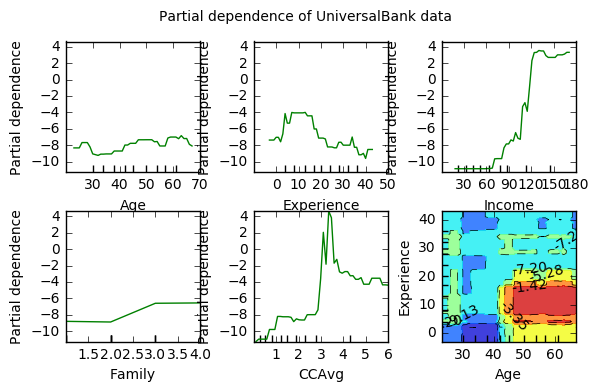

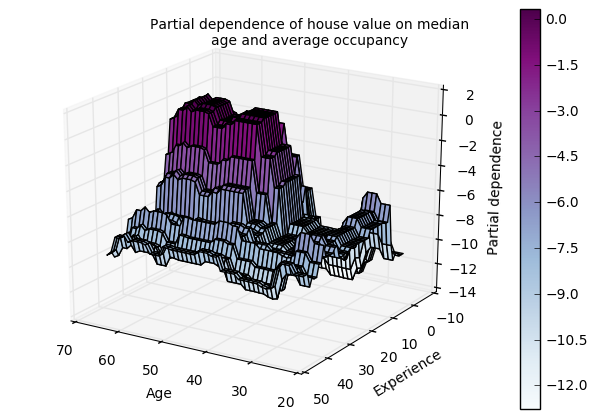

In [124]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

names = X_train.columns
print(names)

#2D Partial dependency plot
#0, 5, 1, 2 번째 변수에 대한 1차원 partial dependency plot 그리기
#(5,1) 번째 변수에 대한 2차원 partial dependency plot 그리기

features = [0, 1, 2, 3, 4, (0, 1)]
fig, axs = plot_partial_dependence(Boosting, X_train, features,
                                       feature_names=names, grid_resolution=50)
fig.suptitle('Partial dependence of UniversalBank data')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle


#3D Partial dependency plot
fig = plt.figure()

target_feature = (0, 1)
pdp, axes = partial_dependence(Boosting, target_feature,
                                   X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
                 'age and average occupancy')
plt.subplots_adjust(top=0.9)

plt.show()

- partial dependency plot의 절대적인 값(logit)은 다른 관측치에 의해 결정되며, 각 변수의 변화에 따른 상대적인 변화가 중요하다.

- 예를 들어, Income과 Age의 경우, 값이 증가함에 따라 pd값이 증가하는 것을 확인할 수 있다. 이는 두 변수값이 증가함에 따라 Personal_Loan 값이 1이 될 확률이 증가함을 의미한다.